# Training Models

## 1. The Normal Equation 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [367]:
x = 2 * np.random.rand(100, 1)
y = 4 + 3 * x + np.random.randn(100, 1)
pd.DataFrame({'x':x[:, 0], 'y':y[:, 0]})

,x,y
0,1.122136,8.728927
1,1.898492,10.207042
2,0.588438,5.578420
3,1.505985,7.467121
4,1.167161,6.496443
...,...,...
95,1.697687,8.328718
96,0.355553,3.610750
97,0.391496,4.854198
98,0.985569,8.668556


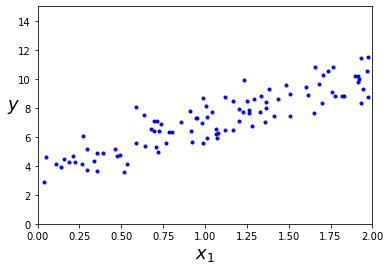

In [368]:
plt.plot(x, y, "b.")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", fontsize = 18, rotation = 0)
plt.axis([0, 2, 0, 15])
plt.show()

Now we use the normal equation to compute the optimum value of theta. 

In [369]:
import numpy.linalg as LA
x_b = np.c_[np.ones((100, 1)), x] # add x0 = 1 to each instance
theta_best = LA.inv(x_b.T.dot(x_b)).dot(x_b.T).dot(y)

In [370]:
theta_best

array([[3.67822801],
       [3.30572783]])

Now we can make predictions with theta_best

In [371]:
x_new = np.array([[0], [2]])
x_new_b = np.c_[np.ones((2, 1)), x_new]

y_predict = x_new_b.dot(theta_best)
y_predict

array([[ 3.67822801],
       [10.28968367]])

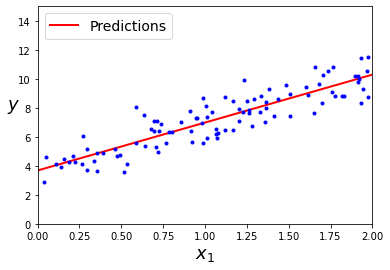

In [372]:
plt.plot(x_new, y_predict, "r-", linewidth = 2, label = "Predictions")
plt.plot(x, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc = "upper left", fontsize = 14)
plt.axis([0, 2, 0, 15])
plt.show()

### Doing it with Scikit-Learn

In [373]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(x, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.67822801]), array([[3.30572783]]))

In [374]:
lin_reg.predict(x_new)

array([[ 3.67822801],
       [10.28968367]])

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for least squares). We can call it directly as well.

In [375]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(x_b, y, rcond=1e-6)
theta_best_svd

array([[3.67822801],
       [3.30572783]])

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the pseudoinverse of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use np.linalg.pinv() to compute the pseudoinverse directly:

In [376]:
np.linalg.pinv(x_b).dot(y)

array([[3.67822801],
       [3.30572783]])

Now we will look at different ways to train a Linear Regression model, better suited for cases where there are a large number of features, or too many instances to fit in memory

## 2. Gradient Descent

The Normal Equation computes the inverse of $\mathbf{X}^T\mathbf{X}$, which is an (n + 1) × (n + 1)
matrix (where n is the number of features). The computational complexity of inverting
such a matrix is typically about O($\mathbf{n}^{2.4}$) to O($\mathbf{n}^3$) (depending on the implementation).
In other words, if you double the number of features, you multiply the computation
time by roughly $\mathbf{2}^{2.4}$ = 5.3 to $\mathbf{2}^3$ = 8.

The SVD approach used by Scikit-Learn’s LinearRegression class is about O($\mathbf{n}^2$). If
you double the number of features, you multiply the computation time by roughly 4.

Also, once you have trained your Linear Regression model (using the Normal Equation
or any other algorithm), predictions are very fast: the computational complexity
is linear with regards to both the number of instances you want to make predictions
on and the number of features. In other words, making predictions on twice as many
instances (or twice as many features) will just take roughly twice as much time.
Now we will look at very different ways to train a Linear Regression model, better
suited for cases where there are a large number of features, or too many training
instances to fit in memory.

**Gradient Descent** is a very generic optimization algorithm capable of finding optimal
solutions to a wide range of problems. The general idea of Gradient Descent is to
tweak parameters iteratively in order to minimize a cost function.

Concretely, you start by filling θ with random values (this is called random initialization),
and then you improve it gradually, taking one baby step at a time, each step
attempting to decrease the cost function (e.g., the MSE), until the algorithm converges
to a minimum

### Linear Regression with Batch Gradient Descent

In [377]:
eta = 0.1 # Learning rate
n_iterations = 1000
m = 100

In [378]:
theta = np.random.randn(2, 1) # Random initiation

for iteration in range(n_iterations):
    gradients = 2/m * x_b.T.dot(x_b.dot(theta) - y)
    theta = theta - eta * gradients
theta

array([[3.67822801],
       [3.30572783]])

The main problem with Batch Gradient Descent is the fact that it uses the whole
training set to compute the gradients at every step, which makes it very slow when
the training set is large.

## Stochastic Gradient Descent

Stochastic Gradient Descent just
picks a random instance in the training set at every step and computes the gradients
based only on that single instance. Obviously this makes the algorithm much faster
since it has very little data to manipulate at every iteration. It also makes it possible to
train on huge training sets, since only one instance needs to be in memory at each
iteration (SGD can be implemented as an out-of-core algorithm.)

When the cost function is very irregular, this can actually help the
algorithm jump out of local minima, so Stochastic Gradient Descent has a better
chance of finding the global minimum than Batch Gradient Descent does.

Therefore randomness is good to escape from local optima, but bad because it means
that the algorithm can never settle at the minimum. One solution to this dilemma is
to gradually reduce the learning rate. The steps start out large (which helps make
quick progress and escape local minima), then get smaller and smaller, allowing the
algorithm to settle at the global minimum.

This process is akin to simulated annealing,
an algorithm inspired from the process of annealing in metallurgy where molten
metal is slowly cooled down. The function that determines the learning rate at each
iteration is called the learning schedule. If the learning rate is reduced too quickly, you
may get stuck in a local minimum, or even end up frozen halfway to the minimum. If
the learning rate is reduced too slowly, you may jump around the minimum for a
long time and end up with a suboptimal solution if you halt training too early.

In [379]:
n_epochs = 50
t0, t1 = 5, 50 # Learning schedule hyperparemeters

In [380]:
def learning_schedule(t):
    return t0/(t + t1)
theta = np.random.randn(2, 1) # random initialization

In [381]:
for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = x_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
theta

array([[3.66730555],
       [3.34189355]])

To perform Linear Regression using SGD with Scikit-Learn, you can use the `SGDRegressor` class, which defaults to optimizing the squared error cost function.

In [382]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1)
sgd_reg.fit(x, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([3.65219484]), array([3.28847114]))

# 3. Polynomial Regression

What if your data is actually more complex than a simple straight line? Surprisingly,
you can actually use a linear model to fit nonlinear data. A simple way to do this is to
add powers of each feature as new features, then train a linear model on this extended
set of features. This technique is called Polynomial Regression.

We set some random data in the general form $\mathbf{ax}^2 + \mathbf{bx} + \mathbf{c}$

In [383]:
m = 100
x = 6 * np.random.randn(m, 1) - 3
y = 0.5 * x ** 2 + x + 2 + np.random.randn(m , 1)
pd.DataFrame({'x':x.ravel(), 'y':y.ravel()})

,x,y
0,1.427740,3.268796
1,-0.956193,3.082672
2,-1.223092,1.332768
3,8.151627,41.146437
4,-4.281647,6.121810
...,...,...
95,0.469889,2.311018
96,-5.664162,11.419611
97,-7.441960,23.340064
98,2.380801,9.149366


Clearly a straight line will not fit the data properly

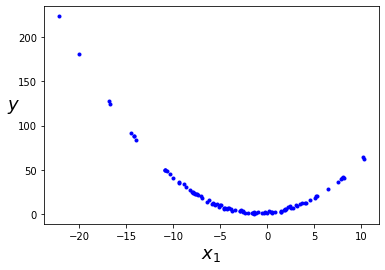

In [384]:
plt.plot(x, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.show()

In [385]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
x_poly = poly_features.fit_transform(x)

X_poly now contains the original feature of X plus the square of this feature. Now you
can fit a LinearRegression model to this extended training data

In [386]:
lin_reg = LinearRegression()
lin_reg.fit(x_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.9027757]), array([[0.94906631, 0.49556744]]))

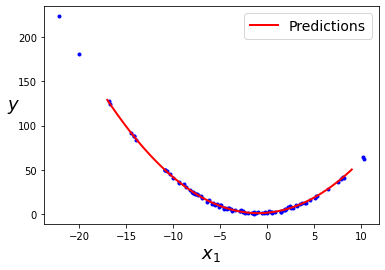

In [387]:
x_new = np.linspace(-17, 9, 100).reshape(100, 1)
x_new_poly = poly_features.transform(x_new)
y_new = lin_reg.predict(x_new_poly)
plt.plot(x, y, "b.")
plt.plot(x_new, y_new, "r-", linewidth = 2, label = "Predictions")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.legend(loc = "upper right", fontsize = 14)
plt.show()

High-degree Polynomial Regression model is prone to overfitting the data. To decide how complex our model should be, we can use cross-validation. 
If a model performs well on training data but poorly on test data, then it is overfitting. If it performs poorly on both, then it is underfitting.

Another way is to look at the learning curve: plots of model's performance on training set and validation set as a function of the training set size. To generate the plots, simply train the model several times on different sized subsets of the training set. The following code defines a function that plots the learning curves of a model given some training data:

In [388]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

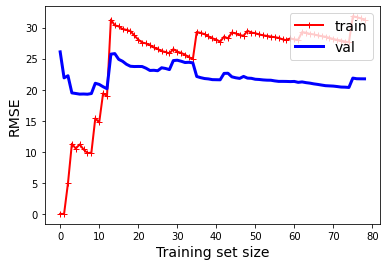

In [389]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, x, y)
plt.show()

First, let’s look at the performance on the training
data: when there are just one or two instances in the training set, the model can fit
them perfectly, which is why the curve starts at zero. But as new instances are added
to the training set, it becomes impossible for the model to fit the training data perfectly,
both because the data is noisy and because it is not linear at all. So the error on
the training data goes up until it reaches a plateau, at which point adding new instances
to the training set doesn’t make the average error much better or worse. Now let’s
look at the performance of the model on the validation data. When the model is
trained on very few training instances, it is incapable of generalizing properly, which
is why the validation error is initially quite big. Then as the model is shown more
training examples, it learns and thus the validation error slowly goes down. However,
once again a straight line cannot do a good job modeling the data, so the error ends
up at a plateau, very close to the other curve.

Now let’s look at the learning curves of a $\mathbf{10}^{th}$-degree polynomial model on the same
data

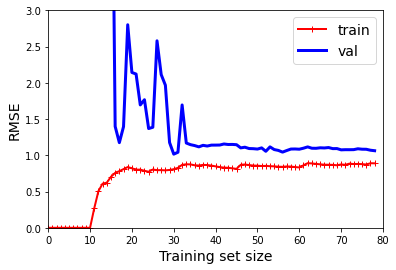

In [390]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])
plot_learning_curves(polynomial_regression, x, y)
plt.axis([0, 80, 0, 3]) 
plt.show()

Here, there are two main differences:

- The error on the training data is much lower than with the Linear Regression model.
- There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. However, if you used a much larger training set, the two curves would continue to get closer.

### The bias/variance tradeoff

An important theoretical result of statistics and Machine Learning is the fact that a model’s generalization error can be expressed as the sum of three very different errors:

#### Bias
> This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.

#### Variance 
> This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data.

#### Irreducible Error
> This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).

Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a tradeoff.

## 4. Regularized Linear Model

A good way to reduce overfitting is to regularize the model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be
for it to overfit the data. For example, a simple way to regularize a polynomial model is to reduce the number of polynomial degrees.

For a linear model, regularization is typically achieved by constraining the weights of the model. We will now look at 

1. Ridge Regression
2. Lasso Regression
3. Elastic Net

which implement three different ways to constrain the weights.

#### 4.1 Ridge Regression

A regularized term is added to the cost function. This forces the algorithm to not only fit the data but also keep the model weights as small as possible. Note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to evaluate the model’s performance using the unregularized performance measure.

In [391]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 1, solver = "cholesky")
ridge_reg.fit(x, y)
ridge_reg.predict([[1.5]])

array([[10.49219876]])

In [393]:
sgd_reg = SGDRegressor(penalty = "l2")
sgd_reg.fit(x, y.ravel())
sgd_reg.predict([[1.5]])

array([7.02641156])

#### 4.2 Lasso Regression

An important characteristic of Lasso Regression is that it tends to completely eliminate the weights of the least important features (i.e., set them to zero). Lasso Regression automatically performs feature selection and outputs a sparse model.

In [396]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(x, y)
lasso_reg.predict([[1.5]])

array([10.49946618])

#### 4.3 Elastic Net

Elastic Net is a middle ground between Ridge Regression and Lasso Regression. The regularization term is a simple mix of both Ridge and Lasso’s regularization terms, and you can control the mix ratio r. When r = 0, Elastic Net is equivalent to Ridge Regression, and when r = 1, it is equivalent to Lasso Regression

So when should you use plain Linear Regression (i.e., without any regularization), Ridge, Lasso, or Elastic Net? It is almost always preferable to have at least a little bit of
regularization, so generally you should avoid plain Linear Regression. Ridge is a good default, but if you suspect that only a few features are actually useful, you should prefer
Lasso or Elastic Net since they tend to reduce the useless features’ weights down to zero as we have discussed. In general, Elastic Net is preferred over Lasso since Lasso
may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

In [397]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elastic_net.fit(x, y)
elastic_net.predict([[1.5]])

array([10.51090461])

### Early stopping

A very different way to regularize iterative learning algorithms such as Gradient Descent is to stop training as soon as the validation error reaches a minimum. This is called early stopping.

In [411]:
x_train, x_val, y_train, y_val = train_test_split(x[:50], y[:50].ravel(), test_size=0.5, random_state=10) # split train test set

from sklearn.preprocessing import StandardScaler
poly_scaler = Pipeline([
    ("poly_feature", PolynomialFeatures(degree = 90, include_bias = False)),
    ("std_scaler", StandardScaler())
])
x_train_poly_scaled = poly_scaler.fit_transform(x_train)
x_val_poly_scaled = poly_scaler.transform(x_val)
sgd_reg = SGDRegressor(max_iter = 1, tol = -np.infty, warm_start = True,
                      penalty = None, learning_rate = "constant", eta0 = 0.0005)

In [414]:
from sklearn.base import clone

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(x_train_poly_scaled, y_train) # Continues where it left off
    y_val_predict = sgd_reg.predict(x_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)    # Constructs a new unfitted estimator with the same parameters.

sgd_reg.intercept_, sgd_reg.coef_

(array([17.11891349]),
 array([ 4.72886196, 17.82970064, -0.67332361,  4.85026797, -0.36166926,
         0.91970732,  0.11430208, -0.03013447,  0.23325759, -0.19345475,
         0.20896007, -0.17531231,  0.1560391 , -0.1299305 ,  0.11013943,
        -0.09185597,  0.07740713, -0.06534897,  0.05578852, -0.0480914 ,
         0.04200749, -0.03717964,  0.03337541, -0.03037555,  0.02801672,
        -0.02616205,  0.02470554, -0.02356194,  0.0226645 , -0.02196035,
         0.02140799, -0.02097475,  0.02063497, -0.02036851,  0.02015957,
        -0.01999572,  0.01986725, -0.01976651,  0.01968753, -0.0196256 ,
         0.01957704, -0.01953897,  0.01950911, -0.01948571,  0.01946736,
        -0.01945297,  0.01944168, -0.01943284,  0.0194259 , -0.01942047,
         0.0194162 , -0.01941286,  0.01941024, -0.01940818,  0.01940657,
        -0.01940531,  0.01940432, -0.01940354,  0.01940293, -0.01940245,
         0.01940208, -0.01940179,  0.01940156, -0.01940138,  0.01940124,
        -0.01940112,  0.0194

## 5. Logistic Regression

In [13]:
from sklearn import datasets
iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns = iris.feature_names)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [19]:
x = iris["data"][:, 3:] # Petal width
y = (iris["target"] == 2).astype(np.int) # 1 if Virginica, else 0

In [22]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x, y)

LogisticRegression()

Let's look at the estimated probabilities for flowers with petal widths from 0 to 3 cm

In [28]:
x_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_prob = log_reg.predict_proba(x_new)
pd.DataFrame(y_prob)

,0,1
0,0.999250,0.000750
1,0.999240,0.000760
2,0.999230,0.000770
3,0.999220,0.000780
4,0.999210,0.000790
...,...,...
995,0.003165,0.996835
996,0.003124,0.996876
997,0.003084,0.996916
998,0.003044,0.996956


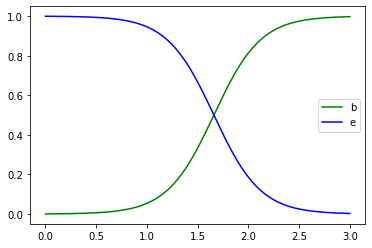

In [30]:
plt.plot(x_new, y_prob[:, 1], 'g-', label = "Iris-Virginica")
plt.plot(x_new, y_prob[:, 0], 'b-', label = "Iris-Non Virginica")
plt.legend("best")
plt.show()

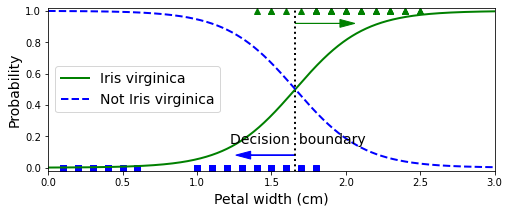

In [47]:
decision_boundary = x_new[y_prob[:, 1] >= 0.5][0] # First x-value that has prob >= 0.5

plt.figure(figsize=(8, 3))
plt.plot(x[y==0], y[y==0], "bs")
plt.plot(x[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(x_new, y_prob[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(x_new, y_prob[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

The petal width of Iris-Virginica (represnted by triangles) ranges from 1.4 to 2.5 cm, while the other iris flowers (represented by squares) generally have a smaller petal width, ranging from 0.1 to 0.8 cm. Notice there is a bit of overlap. 

We can also estimate the probabilities with more than 1 predictor values.

In [57]:
x = iris["data"][:, 2:]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

# C is inverse of regularization strength. Smaller values specify strong regularization
log_reg = LogisticRegression(C = 10**10)
log_reg.fit(x, y)

LogisticRegression(C=10000000000)

In [74]:
x0, x1 = np.meshgrid(
    np.linspace(2.9, 7, 500),
    np.linspace(0.8, 2.7, 200),
)
x_new = np.c_[x0.ravel(), x1.ravel()]
x_new

array([[2.9       , 0.8       ],
       [2.90821643, 0.8       ],
       [2.91643287, 0.8       ],
       ...,
       [6.98356713, 2.7       ],
       [6.99178357, 2.7       ],
       [7.        , 2.7       ]])

In [78]:
y_prob = log_reg.predict_proba(x_new)
pd.DataFrame(y_prob)

,0,1
0,1.000000e+00,1.642700e-09
1,1.000000e+00,1.722235e-09
2,1.000000e+00,1.805621e-09
3,1.000000e+00,1.893044e-09
4,1.000000e+00,1.984700e-09
...,...,...
99995,9.994272e-11,1.000000e+00
99996,9.532730e-11,1.000000e+00
99997,9.092482e-11,1.000000e+00
99998,8.672596e-11,1.000000e+00


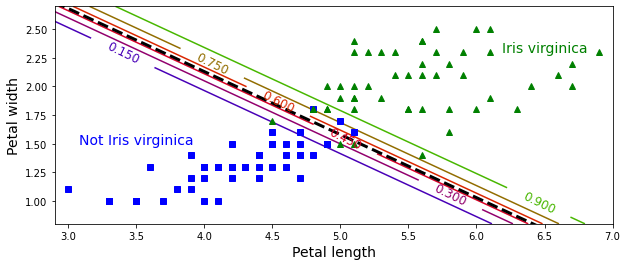

In [100]:
plt.figure(figsize = (10, 4))
plt.plot(x[y == 0, 0], x[y == 0, 1], "bs")
plt.plot(x[y == 1, 0], x[y == 1, 1], "g^")
zz = y_prob[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]
plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

Scikit-Learn’s LogisticRegression uses one-versus-all by default when you train it on more than two classes, but you can set the multi_class hyperparameter to "multinomial" to switch it to Softmax Regression instead. You must also specify a solver that supports Softmax Regression, such as the "lbfgs" solver (see Scikit-Learn’s documentation for more details). It also applies ℓ2 regularization by default, which you can control using the hyperparameter C.

In [102]:
x = iris["data"][:, (2, 3)] # Petal length and width
y = iris["target"]

In [103]:
softmax_reg = LogisticRegression(multi_class = "multinomial", C = 10)
softmax_reg.fit(x, y)

LogisticRegression(C=10, multi_class='multinomial')

An iris with 5 cm long and 2 cm wide petals

In [104]:
softmax_reg.predict([[5, 2]])

array([2])

Class 2, which is Virginica

We can also look at the probabilities of each class

In [106]:
pd.DataFrame(softmax_reg.predict_proba([[5, 2]]))

,0,1,2
0,6.380149e-07,0.057493,0.942506


## Exercise

Implement Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn).

In [222]:
X= iris["data"][:, (2, 3)] # Petal length and width
y = iris["target"]

In [223]:
X_with_bias = np.c_[np.ones([len(X), 1]), X] # Add bias term for every instance

In [224]:
np.random.seed(2042)

##### train_test_split

In [225]:
from sklearn.model_selection import train_test_split

train_ratio = 0.6
test_ratio = 0.2
validation_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_split(X_with_bias, y, test_size = 1-train_ratio)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size = test_ratio/(test_ratio + validation_ratio))

In [226]:
y_train

array([2, 0, 1, 1, 2, 2, 2, 0, 0, 0, 2, 1, 2, 1, 0, 1, 0, 1, 2, 2, 1, 0,
       2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 2, 0, 0, 0, 1, 1, 2, 2,
       1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 1, 0, 0, 1, 1, 2, 1, 2, 2, 1, 1, 1,
       0, 0, 0, 2, 0, 1, 2, 0, 1, 1, 2, 2, 2, 0, 2, 1, 0, 2, 0, 0, 1, 0,
       2, 1])

##### one hot encode

In [227]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

In [228]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

##### Softmax function
>
> $\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [229]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

Define the number of inputs and outputs

In [230]:
n_inputs = x_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

$J(\mathbf{\Theta}) = \dfrac{1}{m}\sum\limits{i=1}^{m}\sum\limits{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting nan values.

In [249]:
eta = 0.01
n_iterations = 300001
m = len((x_train))
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs) # Starting model parameters for gradient descent

In [250]:
for iteration in range(n_iterations):
    logits = x_train.dot(Theta)
    y_prob = softmax(logits)
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(y_prob + epsilon), axis = 1))
    error = y_prob - Y_train_one_hot
    if iteration % 30000 == 0:
        print(iteration, loss)
    gradients = 1/m * x_train.T.dot(error)
    Theta = Theta - eta * gradients

0 4.3803030452054745
30000 0.18983233051584736
60000 0.15002213308372203
90000 0.13268703422678033
120000 0.12274720617027166
150000 0.11622811379426792
180000 0.11159610722265387
210000 0.10812538291940176
240000 0.1054246662740424
270000 0.10326294950459006
300000 0.10149436421369193


In [251]:
Theta

array([[ 12.34151912,   1.71571047, -17.35714433],
       [ -2.40422142,   0.2795687 ,   1.30308809],
       [ -8.07484988,  -2.37372304,   6.16630168]])

Let's make predictions for the validation sets, and check the accuracy score

In [252]:
logits = x_valid.dot(Theta)
y_prob = softmax(logits)
y_predict = np.argmax(y_prob, axis = 1)

accuracy_socre = np.mean(y_predict == y_valid)
accuracy_socre

0.9333333333333333

## Add  $\ell_2$ Regularization

In [275]:
eta = 0.1
n_iterations = 300001
m = len(x_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

In [276]:
for iteration in range(n_iterations):
    logits = x_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    if iteration % 30000 == 0:
        print(iteration, loss)
    gradients = 1/m * x_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 5.808751257202355
30000 0.5019856899446351
60000 0.5019856899446351
90000 0.5019856899446351
120000 0.5019856899446351
150000 0.5019856899446351
180000 0.5019856899446351
210000 0.5019856899446351
240000 0.5019856899446351
270000 0.5019856899446351
300000 0.5019856899446351


In [277]:
logits = x_valid.dot(Theta)
y_prob = softmax(logits)
y_predict = np.argmax(y_prob, axis = 1)

accuracy_socre = np.mean(y_predict == y_valid)
accuracy_socre

0.9666666666666667

## Early stopping

In [288]:
eta = 0.1 
n_iterations = 30000
m = len(x_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

In [289]:
for iteration in range(n_iterations):
    logits = x_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * x_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = x_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 1000 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "Early stopping!")
        break

0 4.774275159850905
1000 0.5245761978682187
2000 0.5101976533812023
3000 0.5069902929702341
4000 0.5059975055487889
5000 0.5056325606666671
6000 0.5054859366869356
7000 0.5054244666833672
8000 0.5053981923151752
9000 0.5053868648809485
10000 0.5053819629705367
11000 0.5053798382022101
12000 0.505378916548985
13000 0.5053785166428658
14000 0.5053783430999207
15000 0.505378267784964
16000 0.5053782350986081
17000 0.5053782209127192
18000 0.5053782147560096
19000 0.5053782120839774
20000 0.5053782109243056
21000 0.5053782104210035
22000 0.5053782102025685
23000 0.5053782101077668
24000 0.5053782100666224
25000 0.5053782100487656
26000 0.5053782100410157
27000 0.5053782100376522
28000 0.5053782100361924
29000 0.5053782100355588
29387 0.5053782100354247
29388 0.5053782100354247 Early stopping!


In [290]:
logits = x_valid.dot(Theta)
y_prob = softmax(logits)
y_predict = np.argmax(y_prob, axis = 1)

accuracy_socre = np.mean(y_predict == y_valid)
accuracy_socre

0.9666666666666667

Measure the accuracy on test set

In [291]:
logits = x_test.dot(Theta)
y_prob = softmax(logits)
y_predict = np.argmax(y_prob, axis = 1)

accuracy_socre = np.mean(y_predict == y_test)
accuracy_socre

1.0